## Imports and costants

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.models import Model

In [2]:
(imgs, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
imgs = imgs / 255.0

In [3]:
img_shape = imgs[0].shape
img_size = img_shape[0]
treshold = 0.25

## Preprocess data

In [4]:
spoil_imgs = []
for img in imgs:
    miss_indexes = np.random.uniform(size=img_shape)
    spoil_img = img.copy()
    spoil_img[miss_indexes>treshold] = 0
    spoil_imgs.append(spoil_img)
spoil_imgs = np.asarray(spoil_imgs)

In [5]:
def visualize(img, spoil_img, rec_img):
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1).imshow(img)
    plt.title('Original image')
    
    plt.subplot(1,3,2).imshow(spoil_img)
    plt.title('Image with missed pixels')
    
    plt.subplot(1,3,3).imshow(rec_img)
    plt.title('Recovered image')

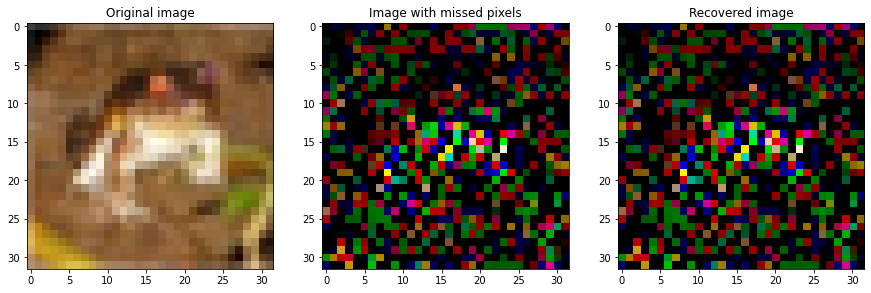

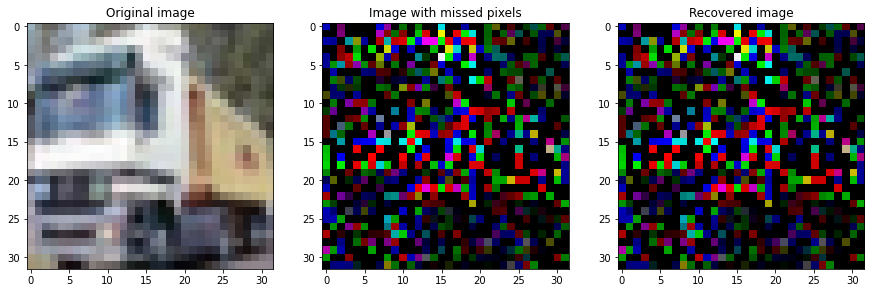

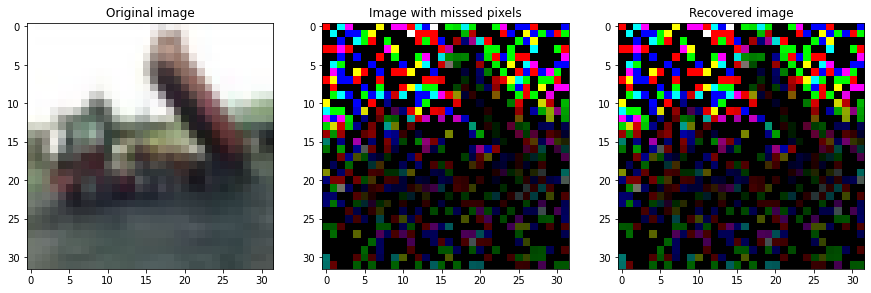

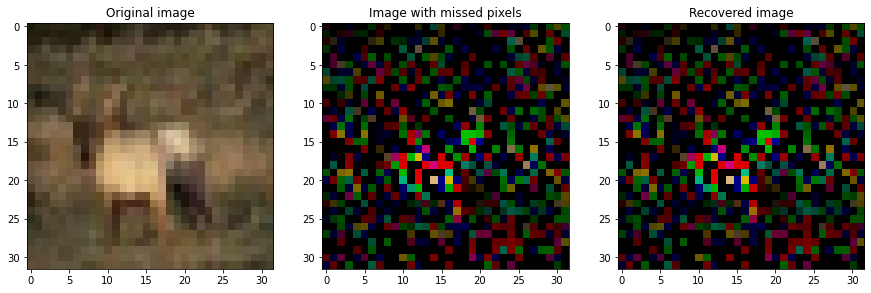

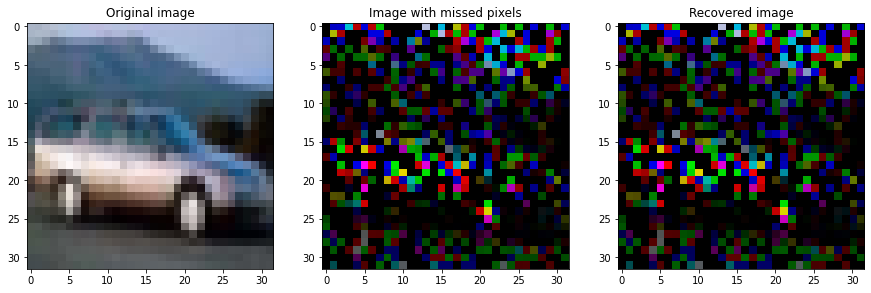

In [6]:
for img, spoil_img in zip(imgs[:5], spoil_imgs[:5]):
    visualize(img, spoil_img, spoil_img)

## Build network

In [9]:
def down_blok(num_f, x):
    x1 = Conv2D(num_f, (3,3), padding='same', activation='relu')(x)
    x1 = Conv2D(2*num_f, (3,3), padding='same', activation='relu')(x)
    x1 = Conv2D(3*num_f, (3,3), padding='same', activation='relu')(x)
    x = Concatenate()([x,x1])
    x = Conv2D(2*num_f, (3,3),strides=(2,2), padding='same', activation='relu')(x)
    return x

def up_blok(num_f, x1,x2):
    x = Concatenate()([x1,x2])
    x = Conv2DTranspose(num_f, (3,3), (2,2), padding='same')(x)
    return x

In [10]:
img = keras.Input(img_shape)
d1 = down_blok(32, img)
d2 = down_blok(64, d1)
d3 = down_blok(128, d2)
d4 = Conv2D(256, (2,2), strides=(2,2), padding='same', activation='relu')(d3)
# u3 = UpSampling2D()(d4)
u4 = Conv2DTranspose(256, (2,2), strides=(2,2))(d4)
u3 = up_blok(128, u4,d3)
u2 = up_blok(128, u3,d2)
u1 = up_blok(128, u2,d1)
out = Concatenate()([u1, img])
out = Conv2DTranspose(3, (3,3), padding='same')(out)
unet_model = Model(img, out)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 96)   2688        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 99)   0           ['input_1[0][0]',                
                                                                  'conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   57088       ['concatenate[0][0]']        

In [11]:
class RecoveryModel(Model):
    
    def __init__(self, unet_network):
        super(RecoveryModel, self).__init__()
        self.unet_network = unet_network
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.unet_network(inputs)
    
    def train_step(self, data):
        spoil_img, img = data
        with tf.GradientTape() as tape:
            rec_img = self.unet_network(spoil_img, training=True)
            loss = self._compute_loss(spoil_img, img, rec_img)
        
        gradients = tape.gradient(loss, self.unet_network.trainable_weights)
        
        self.optimizer.apply_gradients(zip(gradients, self.unet_network.trainable_weights))

        # update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, spoil_img, img, rec_img):
        miss_indexes = tf.where(spoil_img == 0)
        gt_indexes = tf.where(spoil_img != 0)
        
        miss_rec_img = tf.gather_nd(rec_img, miss_indexes)
        miss_img = tf.gather_nd(img, miss_indexes)
        miss_loss = tf.reduce_mean((miss_img-miss_rec_img)**2)
        
        gt_rec_img = tf.gather_nd(rec_img, gt_indexes)
        gt_img = tf.gather_nd(img, gt_indexes)
        gt_loss = tf.reduce_mean((gt_img-gt_rec_img)**2)
        
        
        loss = miss_loss + gt_loss
        return loss
    
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [12]:
model = RecoveryModel(unet_model)
model.compile(optimizer=keras.optimizers.Adam(0.0001))
model.fit(spoil_imgs, imgs, batch_size=128, epochs=5)

Epoch 1/5
391/391 [==============================] - 64s 157ms/step - loss: 0.0480
Epoch 2/5
391/391 [==============================] - 59s 150ms/step - loss: 0.0176
Epoch 3/5
391/391 [==============================] - 59s 151ms/step - loss: 0.0150
Epoch 4/5
391/391 [==============================] - 59s 151ms/step - loss: 0.0132
Epoch 5/5
391/391 [==============================] - 59s 150ms/step - loss: 0.0119


## Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


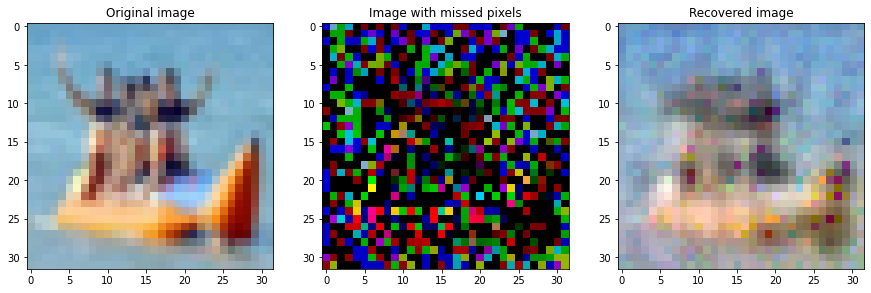

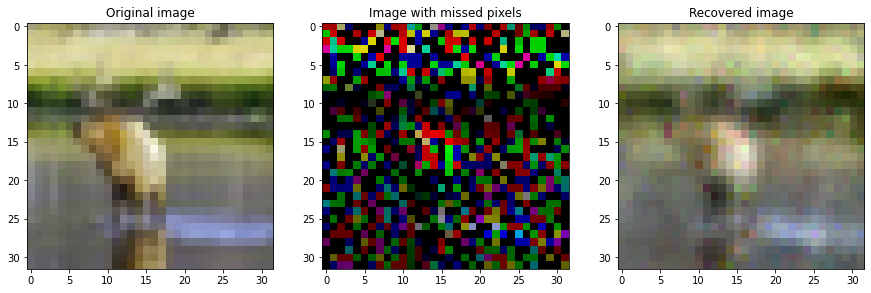

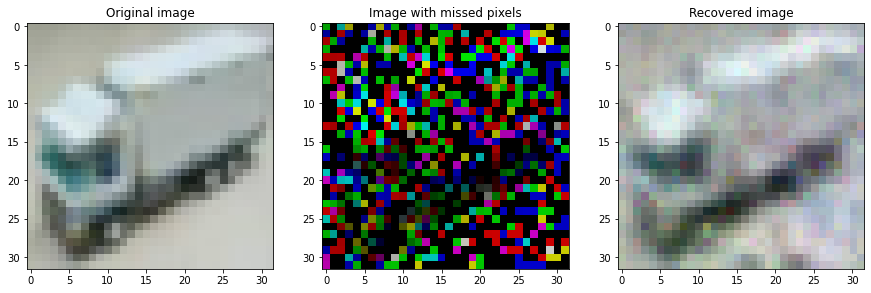

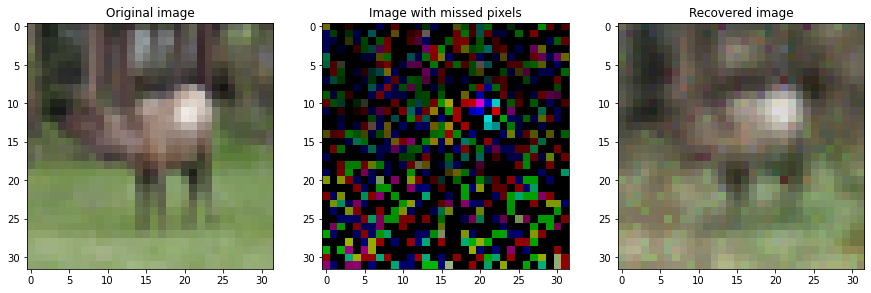

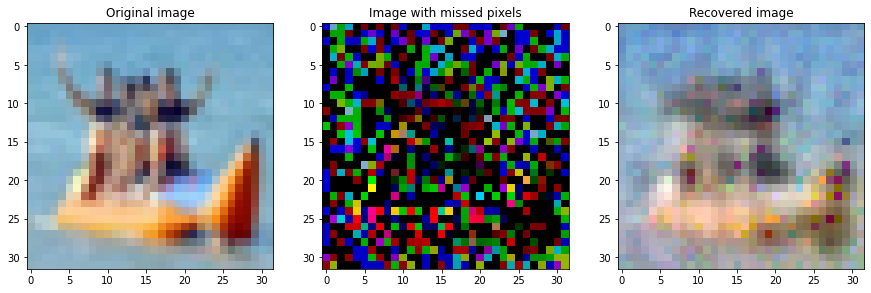

In [14]:
rec_imgs = model.predict(spoil_imgs[:100])

# use predictions only for missed pixels
gt_indexes = np.where(spoil_imgs[:100]!=0)
rec_imgs[gt_indexes] = imgs[:100][gt_indexes]
for _ in range(5):
    n = np.random.choice(100)
    
    img = imgs[n]
    spoil_img = spoil_imgs[n]
    rec_img = rec_imgs[n]
    
    visualize(img, spoil_img, rec_img)